In [1]:
# Loading required libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from scipy import stats

In [2]:
# Read data files into data frames
df = pd.read_csv('/content/drive/MyDrive/Forage-QVI/QVI_data.csv')
df

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream
...,...,...,...,...,...,...,...,...,...,...,...,...
264829,2370701,2018-12-08,88,240378,24,Grain Waves Sweet Chilli 210g,2,7.2,210,GRNWVES,YOUNG FAMILIES,Mainstream
264830,2370751,2018-10-01,88,240394,60,Kettle Tortilla ChpsFeta&Garlic 150g,2,9.2,150,KETTLE,YOUNG FAMILIES,Premium
264831,2370961,2018-10-24,88,240480,70,Tyrrells Crisps Lightly Salted 165g,2,8.4,165,TYRRELLS,OLDER FAMILIES,Budget
264832,2370961,2018-10-27,88,240481,65,Old El Paso Salsa Dip Chnky Tom Ht300g,2,10.2,300,OLD,OLDER FAMILIES,Budget


The client has selected store numbers 77, 86 and 88 as trial stores with a trial period of Feb 2019 to April 2019. The client also wants control stores to be established stores that are operational for the entire observation period.

We would want to match trial stores to control stores that are similar to the trial store prior to the trial period of Feb 2019 in terms of:

* Monthly overall sales revenue
* Monthly number of customers
* Monthly number of transactions per custome

To choose the control stores, we will create the metrics of interest and filter to stores that are present throughout the pre-trial period.

First, we want to add a column with the year/month of the transaction.

In [3]:
# Change DATE column to store dates as datetimes
df['DATE'] = pd.to_datetime(df['DATE'])

# Then add a YEARMONTH column
df['YEARMONTH'] = df['DATE'].dt.strftime('%Y%m').astype('int64')
df

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER,YEARMONTH
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium,201810
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream,201809
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget,201903
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget,201903
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream,201811
...,...,...,...,...,...,...,...,...,...,...,...,...,...
264829,2370701,2018-12-08,88,240378,24,Grain Waves Sweet Chilli 210g,2,7.2,210,GRNWVES,YOUNG FAMILIES,Mainstream,201812
264830,2370751,2018-10-01,88,240394,60,Kettle Tortilla ChpsFeta&Garlic 150g,2,9.2,150,KETTLE,YOUNG FAMILIES,Premium,201810
264831,2370961,2018-10-24,88,240480,70,Tyrrells Crisps Lightly Salted 165g,2,8.4,165,TYRRELLS,OLDER FAMILIES,Budget,201810
264832,2370961,2018-10-27,88,240481,65,Old El Paso Salsa Dip Chnky Tom Ht300g,2,10.2,300,OLD,OLDER FAMILIES,Budget,201810


Next, we want to create a function that will be able to calculate the total sales, number of customers, transactions per customer, chips per customer and the average price per unit for each store and month

In [4]:
# Define the metrics and calculate them
grouped_df = df.groupby(["STORE_NBR","YEARMONTH"])
tot_sales = grouped_df.TOT_SALES.sum()
n_cust = grouped_df.LYLTY_CARD_NBR.nunique()
ntrans_percust = grouped_df.TXN_ID.size()/n_cust
nchips_pertrans = grouped_df.PROD_QTY.sum()/grouped_df.TXN_ID.size()
avg_priceperunit = tot_sales/grouped_df.PROD_QTY.sum()
# Put the metrics together in an array
metric_arrays =  [tot_sales, n_cust, ntrans_percust, nchips_pertrans, avg_priceperunit]

# Create the metrics table fro mthe array
metrics_df = pd.concat(metric_arrays, axis=1)
# Give the columns labels
metrics_df.columns = ['tot_sales', 'n_cust', 'ntrans_percust', 'nchips_pertrans', 'avg_priceperunit']
metrics_df = metrics_df.reset_index()

In [5]:
# Filter to select the stores with full observation periods
month_counts = metrics_df.groupby('STORE_NBR').YEARMONTH.nunique().reset_index()
stores_fullobs = month_counts[month_counts.YEARMONTH ==12].STORE_NBR
pretrial_metrics = metrics_df[metrics_df['STORE_NBR'].isin(stores_fullobs)]

# Then filter to keep only the pre-trial period data
pretrial_metrics = pretrial_metrics.loc[pretrial_metrics.YEARMONTH < 201902]
pretrial_metrics

,STORE_NBR,YEARMONTH,tot_sales,n_cust,ntrans_percust,nchips_pertrans,avg_priceperunit
0,1,201807,206.9,49,1.061224,1.192308,3.337097
1,1,201808,176.1,42,1.023810,1.255814,3.261111
2,1,201809,278.8,59,1.050847,1.209677,3.717333
3,1,201810,188.1,44,1.022727,1.288889,3.243103
4,1,201811,192.6,46,1.021739,1.212766,3.378947
...,...,...,...,...,...,...,...
3159,272,201809,304.7,32,1.125000,1.972222,4.291549
3160,272,201810,430.6,44,1.159091,1.941176,4.349495
3161,272,201811,376.2,41,1.097561,1.933333,4.324138
3162,272,201812,403.9,47,1.000000,1.893617,4.538202


Now we need to work out a way of ranking how similar each potential control store is to the trial store. We can calculate how correlated the performance of each potential control store is to the trial store.

In [6]:
# Write a function to calculate the correlation between a trial store and all possible control stores
# Inputs:
    # trial (int) : the trial store to test
    # metric_col (str) : the label of the metric column to correlate
    # input_table (df) : the full data table of metrics to obtain the correlations with
# Output:
    # corr_table (df) : a data frame with the year-month, trial store, control store and their correlation

def calc_corr(trial, metric_col, input_table = pretrial_metrics):
    trial_stores = [77, 86, 88]
    control_stores = stores_fullobs[~stores_fullobs.isin(trial_stores)] # all stores but trial stores
    # Keep the trial store values to perform correlation with
    trial_vals = input_table[input_table["STORE_NBR"] == trial][metric_col].reset_index()
    corr_table = pd.DataFrame(columns = ['YEARMONTH', 'trial_store', 'control_store', 'correlation'])
    # Find the correlation for each control store
    for control in control_stores:
        # Keep the control store values to perform correlation with
        control_vals = input_table[input_table["STORE_NBR"] == control][metric_col].reset_index()
        corr_row = pd.DataFrame(columns = ['YEARMONTH', 'trial_store', 'control_store', 'correlation'])
        corr_row.YEARMONTH = list(input_table.loc[input_table.STORE_NBR == control]["YEARMONTH"])
        corr_row.trial_store = trial
        corr_row.control_store = control
        corr_row.correlation = control_vals.corrwith(trial_vals, axis=1)
        corr_table = pd.concat([corr_table, corr_row]) # add each store's block to the dataframe
    return (corr_table)

In [7]:
trial_stores = [77, 86, 88]
corr_table = pd.DataFrame(columns = ['YEARMONTH', 'trial_store', 'control_store', 'correlation'])
for store in trial_stores:
    corr_section = calc_corr(store, ['tot_sales', 'n_cust', 'ntrans_percust', 'nchips_pertrans', 'avg_priceperunit'] )
    corr_table = pd.concat([corr_table, corr_section])

In [8]:
corr_table

,YEARMONTH,trial_store,control_store,correlation
0,201807,77,1,0.070544
1,201808,77,1,0.027332
2,201809,77,1,0.002472
3,201810,77,1,-0.019991
4,201811,77,1,0.030094
...,...,...,...,...
2,201809,88,272,0.533160
3,201810,88,272,0.591056
4,201811,88,272,0.566378
5,201812,88,272,0.594442


Apart from correlation, we can also calculate a standardised metric based on the absolute difference between the trial store's performance and each control store's performance. Write a function to calculate the magnitude distance.

In [9]:
# Write a function to calculate the normalised distance magnitude between a trial store and all possible control stores
# Inputs:
    # trial (int) : the trial store to test
    # metric_col (str) : the label of the metric column to correlate
    # input_table (df) : the full data table of metrics to obtain the correlations with
# Output:
    # corr_table (df) : a data frame with the year-month, trial store, control store and their normalised distance

def calc_magdist(trial, metric_col, input_table = pretrial_metrics):
    trial_stores = [77, 86, 88]
    control_stores = stores_fullobs[~stores_fullobs.isin(trial_stores)] # all stores but the trials
    dist_table = pd.DataFrame() # to store the distances for each store and month
    for control in control_stores: # calculate for each control store
        dist_row = pd.DataFrame()
        # Calculate the distance as an absolute value
        dist_row = abs(input_table[input_table["STORE_NBR"] == trial].reset_index()[metric_col]\
                        - input_table[input_table["STORE_NBR"] == control].reset_index()[metric_col])
        dist_row.insert(0,'YEARMONTH', list(input_table.loc[input_table.STORE_NBR == trial]["YEARMONTH"]))
        dist_row.insert(1,'trial_store', trial)
        dist_row.insert(2,'control_store', control)
        dist_table = pd.concat([dist_table, dist_row])

    for col in metric_col: # then loop over each column to find the max and min distances to normalise
        maxdist = dist_table[col].max()
        mindist = dist_table[col].min()
        dist_table[col] = 1-(dist_table[col] - mindist)/(maxdist-mindist) # normalised distance measure
        # also give an average magnitude over all metrics per month and store pair
    dist_table['mag_measure'] = dist_table[metric_col].mean(axis=1)
    return (dist_table)

Now we will use the functions to find the control stores! We'll select control stores based on how similar monthly total sales in dollar amounts and monthly number of customers are to the trial stores. So we will need to use our functions to get four scores, two for each of total sales and total customers.

In [10]:
# Write a function to generate a table of averaged correlations, distance and scores over the pretrial months for each store
# Inputs:
    # trial (int) : the trial store to test
    # metric_col (str) : the metric label to calculate the scores for
    # input_table (df) : the data to calculate the scores with in the pre-trial period
# Output:
    # avg_corrmag (df) : a table with the correlations, distance and scores averaged over the pretrial months for each store
def calc_corrdist_score (trial, metric_col, input_table=pretrial_metrics):
    # Calculate the correlations and magnitudes for all months
    corr_vals = calc_corr(trial, metric_col, input_table)
    mag_vals = calc_magdist(trial, metric_col, input_table)
    mag_vals = mag_vals.drop(metric_col, axis=1) # For one metric, the two columns will be duplicates so drop one

    # Combine correlations and magnitudes together to one df
    combined_corr_dist = pd.merge(corr_vals, mag_vals, on=["YEARMONTH", "trial_store", "control_store"])

    # Average correlations and distances over the pre-trial months
    avg_corrmag = combined_corr_dist.groupby(["trial_store", "control_store"]).mean().reset_index()

    # Find a combined score by taking the weighted average of the correlations and magnitudes
    corr_weight = 0.5
    avg_corrmag['combined_score'] = corr_weight*avg_corrmag['correlation'] + (1-corr_weight)*avg_corrmag['mag_measure']

    return(avg_corrmag)

In [11]:
# Write a function to output the 5 stores with the highest averaged scores combining the tot_sales and n_cust metrics
# for a given trial store over the pre-trial period
# Inputs:
    # trial (int) : the trial store to test
# Output:
    # scores (df) : a sorted table with the 5 highest composite scores of possible control stores

def find_highestscore(trial):
    # Obtain the scores for the tot_sales and n_cust metrics separately
    scores_tot_sales = calc_corrdist_score (trial, ['tot_sales'])
    scores_n_cust = calc_corrdist_score (trial, ['n_cust'])
    # Create a data table to store the composite results in - stores are also
    scores_control = pd.DataFrame()
    scores_control['control_store'] = scores_tot_sales.control_store
    # Calculate the composite scores
    scores_control['correlation'] = 0.5*scores_tot_sales.correlation + 0.5*scores_n_cust.correlation
    scores_control['mag_measure'] = 0.5*scores_tot_sales.mag_measure + 0.5*scores_n_cust.mag_measure
    scores_control['scores'] = 0.5*scores_tot_sales.combined_score + 0.5*scores_n_cust.combined_score
    return(scores_control.sort_values(by = 'scores', ascending = False).reset_index(drop = True).head(5))

In [12]:
# Now find the control stores with the highest scores for each of the trial stores
trial_stores = [77, 86, 88]
for trial in trial_stores:
    print('Trial store: ', trial)
    print(find_highestscore(trial))
    print()

Trial store:  77


<ipython-input-10-a87ed8c6c01f>:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avg_corrmag = combined_corr_dist.groupby(["trial_store", "control_store"]).mean().reset_index()
<ipython-input-10-a87ed8c6c01f>:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avg_corrmag = combined_corr_dist.groupby(["trial_store", "control_store"]).mean().reset_index()


   control_store  correlation  mag_measure    scores
0            233          1.0     0.989804  0.994902
1             41          1.0     0.972041  0.986020
2             46          1.0     0.969523  0.984762
3             53          1.0     0.968421  0.984211
4            111          1.0     0.967981  0.983991

Trial store:  86


<ipython-input-10-a87ed8c6c01f>:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avg_corrmag = combined_corr_dist.groupby(["trial_store", "control_store"]).mean().reset_index()
<ipython-input-10-a87ed8c6c01f>:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avg_corrmag = combined_corr_dist.groupby(["trial_store", "control_store"]).mean().reset_index()


   control_store  correlation  mag_measure    scores
0            155          1.0     0.976324  0.988162
1            109          1.0     0.968180  0.984090
2            225          1.0     0.965044  0.982522
3            229          1.0     0.957995  0.978997
4            101          1.0     0.945394  0.972697

Trial store:  88


<ipython-input-10-a87ed8c6c01f>:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avg_corrmag = combined_corr_dist.groupby(["trial_store", "control_store"]).mean().reset_index()


   control_store  correlation  mag_measure    scores
0             40          1.0     0.941789  0.970895
1             26          1.0     0.917859  0.958929
2             72          1.0     0.908157  0.954079
3             58          1.0     0.900435  0.950217
4             81          1.0     0.887572  0.943786



<ipython-input-10-a87ed8c6c01f>:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avg_corrmag = combined_corr_dist.groupby(["trial_store", "control_store"]).mean().reset_index()


From the above output, the stores with the highest scores are:

* Store 233 for trial store 77
* Store 155 for trial store 86
* Store 40 for trial stre 88

Note that the combined store for the control cases of trial store 88 are lower than those of stores 77 and 86. This may suggest that the control stores may not match store 88 as well as for the other trial stores.

Now that we have found the control stores, we can visually check if the drivers are similar between these and the trial stores in the pre-trial period.

In [13]:
def make_plots(storepair, metric_col):
    trial = storepair[0]
    control = storepair[1]
    trial_plot = pretrial_metrics[pretrial_metrics.STORE_NBR == trial][['YEARMONTH', 'STORE_NBR', metric_col]]
    trial_plot = trial_plot.rename(columns = {metric_col: metric_col+'_trial'})
    control_plot = pretrial_metrics[pretrial_metrics.STORE_NBR == control][['YEARMONTH', 'STORE_NBR', metric_col]]
    control_plot = control_plot.rename(columns = {metric_col: metric_col+'_control'})

    other_stores = pretrial_metrics.loc[(pretrial_metrics.STORE_NBR != 77)][['YEARMONTH', 'STORE_NBR', metric_col]]
    other_stores = other_stores.loc[(pretrial_metrics.STORE_NBR != 233)]
    plot_other = other_stores.groupby('YEARMONTH')[metric_col].mean()

    ax = control_plot.plot.line(x = "YEARMONTH", y = metric_col+'_control', use_index=False, label = 'Control '+metric_col)
    ax_trial = trial_plot.plot.line(x = "YEARMONTH", y = metric_col+'_trial', use_index=False, ax=ax, label = 'Trial '+metric_col)
    ax_other = plot_other.plot.line(use_index = False, ax=ax, label = 'Other '+ metric_col)
    ax.set_ylabel(metric_col)
    plt.legend(title = 'STORE_NBR', loc = "upper left",bbox_to_anchor=(1.0, 1.0))
    positions = (0,1,2,3,4,5,6)
    labels = ("201807", '201808', '201809', '201810', '201811', '201812', '201901')
    plt.xticks (positions, labels)
    titlestr = 'The Trial Store ' + str(storepair[0]) + ' and Control Store ' + str(storepair[1]) + ' in the Pre-Trial Period'
    ax.set_title(titlestr)

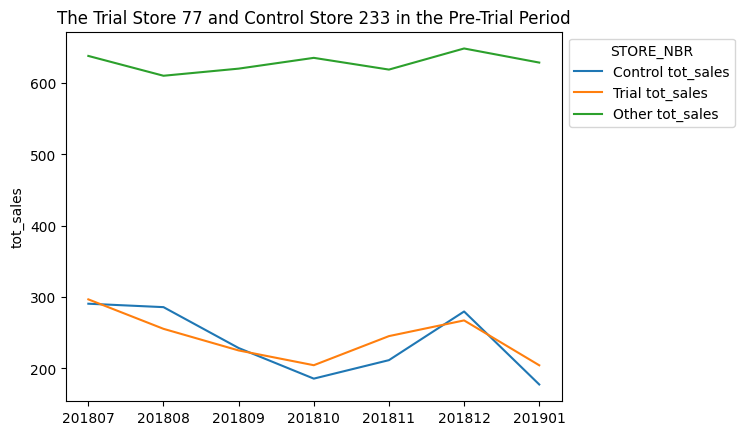

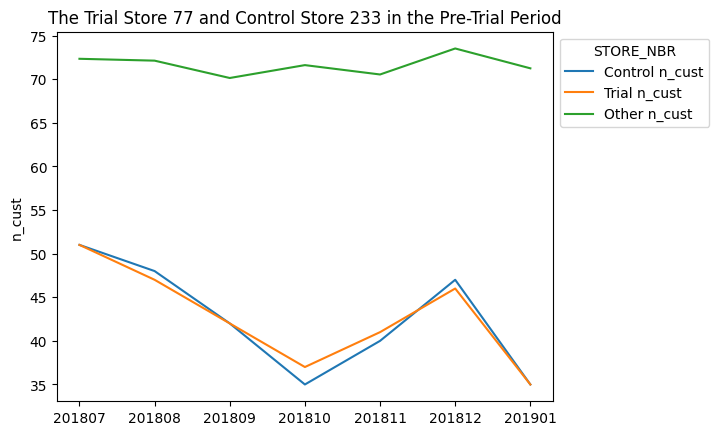

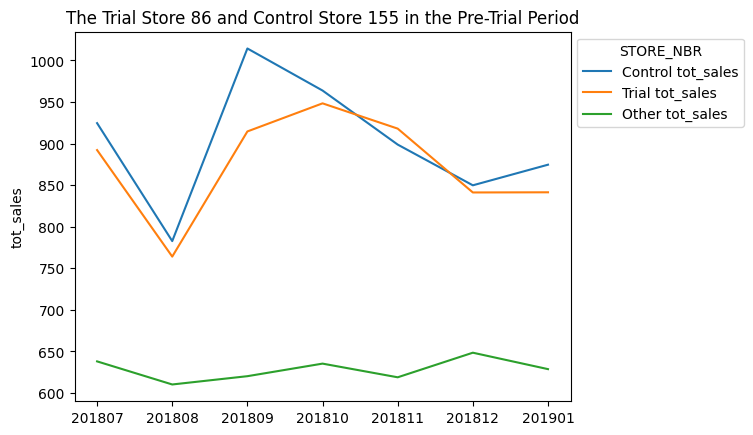

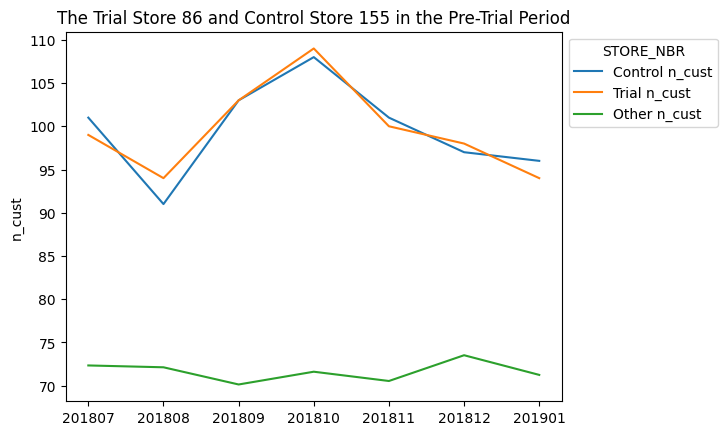

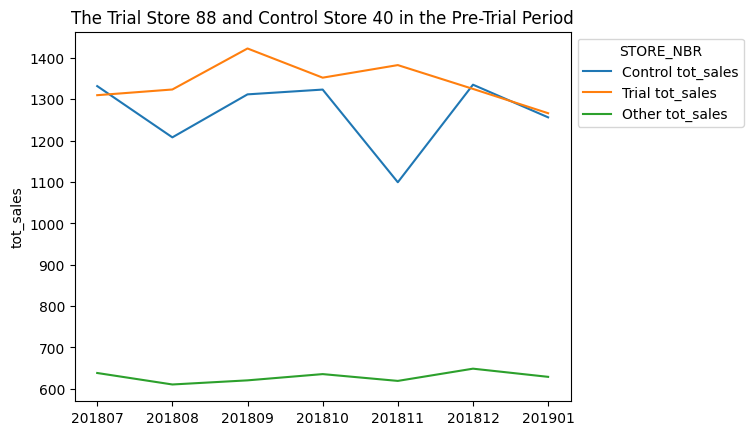

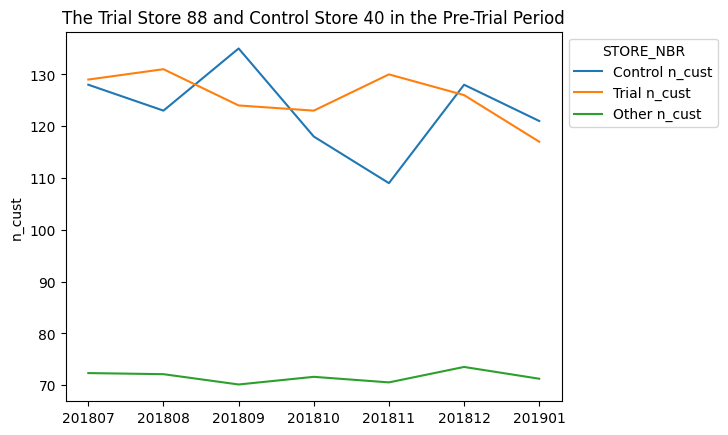

In [14]:
storepair = [[77, 233], [86, 155], [88, 40]]
metric_col = ['tot_sales', 'n_cust']
for pair in storepair:
    for metric in metric_col:
        make_plots(pair, metric)

The metrics of the control and trial stores look reasonably similar in the pre-trial period.

Now, we want to see if there has been an uplift in overall chip sales. We'll start with scaling the control store's sales to a level similar to control for any differences between the two stores outside of the trial period.

In [15]:
# Calculate the scaling factor for the store pairs
scale_store77 = pretrial_metrics[pretrial_metrics.STORE_NBR == 77]['tot_sales'].sum()/pretrial_metrics[pretrial_metrics.STORE_NBR == 233]['tot_sales'].sum()
scale_store86 = pretrial_metrics[pretrial_metrics.STORE_NBR == 86]['tot_sales'].sum()/pretrial_metrics[pretrial_metrics.STORE_NBR == 155]['tot_sales'].sum()
scale_store88 = pretrial_metrics[pretrial_metrics.STORE_NBR == 88]['tot_sales'].sum()/pretrial_metrics[pretrial_metrics.STORE_NBR == 40]['tot_sales'].sum()

In [16]:
# Extract the control store data from the df and scale according to the store
scaled_control233 = metrics_df[metrics_df.STORE_NBR.isin([233])][['STORE_NBR', "YEARMONTH", 'tot_sales']]
scaled_control233.tot_sales *= scale_store77
scaled_control155 = metrics_df[metrics_df.STORE_NBR.isin([155])][['STORE_NBR', "YEARMONTH", 'tot_sales']]
scaled_control155.tot_sales *= scale_store86
scaled_control40 = metrics_df[metrics_df.STORE_NBR.isin([40])][['STORE_NBR', "YEARMONTH", 'tot_sales']]
scaled_control40.tot_sales *= scale_store88

# Combine the scaled control stores to a single df
scaledsales_control = pd.concat([scaled_control233, scaled_control155, scaled_control40]).reset_index(drop = True)
scaledsales_control = scaledsales_control.rename(columns = {'tot_sales':'scaled_tot_sales', 'STORE_NBR': 'CONTROL_NBR'})
# Get the trial period of scaled control stores
scaledsales_control_trial = scaledsales_control[(scaledsales_control.YEARMONTH>=201902) & (scaledsales_control.YEARMONTH<=201904)].reset_index(drop = True)

# Get the trial period of the trial stores
trialsales = metrics_df[metrics_df.STORE_NBR.isin([77,86,88])][['STORE_NBR', "YEARMONTH", 'tot_sales']].reset_index(drop = True)
trialsales = trialsales.rename(columns = {'STORE_NBR': 'TRIAL_NBR'})
trialsales_trial = trialsales[(trialsales.YEARMONTH >= 201902) & (trialsales.YEARMONTH <= 201904)].reset_index(drop = True)

Now that we have comparable sales figures for the control store, we can calculate the percentage difference between the scaled control sales and the trial store's sales during the trial period

In [17]:
# Calculate the percentage difference between the control and trial store pairs for each month over the year
percentdiff = scaledsales_control.copy()
percentdiff[['TRIAL_NBR', 'tot_sales_t']] = trialsales[['TRIAL_NBR', 'tot_sales']]
percentdiff = percentdiff.rename(columns = {'scaled_tot_sales' : 'scaled_sales_c'})
percentdiff['sales_percent_diff'] = (percentdiff.tot_sales_t-percentdiff.scaled_sales_c)\
                                    /(0.5*((percentdiff.scaled_sales_c+percentdiff.tot_sales_t)))
percentdiff.head()

,CONTROL_NBR,YEARMONTH,scaled_sales_c,TRIAL_NBR,tot_sales_t,sales_percent_diff
0,233,201807,297.565550,77,296.8,-0.002576
1,233,201808,292.652187,77,255.5,-0.135554
2,233,201809,233.998916,77,225.2,-0.038323
3,233,201810,190.085733,77,204.5,0.073060
4,233,201811,216.597421,77,245.3,0.124281


Let's see if the difference is significant using a t-test. Our null hypothesis is that the trial period is the same as the pre-trial period; we will test with a null hypothesis that there is a 0-percent between the trial and control stores.

In [18]:
# As our null hypothesis is that the trial period is the same as the pre-trial period,
# let's take the standard deviation based on the scaled percentage difference in the pre-trial period.
pretrial_percentdiff = percentdiff[percentdiff.YEARMONTH < 201902]
pretrial_percentdiff_std = pretrial_percentdiff.groupby(['TRIAL_NBR'])['sales_percent_diff'].agg('std').reset_index()
dof = 6 # 7 months of data - 1

for stores in storepair: # stores numbers are stored as [trial, control] in storepair
    trialstore = stores[0]
    controlstore = stores[1]
    pretrial = percentdiff[(percentdiff.YEARMONTH < 201902) & (percentdiff.TRIAL_NBR == trialstore)]
    std = pretrial['sales_percent_diff'].agg('std')
    mean =  pretrial['sales_percent_diff'].agg('mean')
    trialperiod = percentdiff[(percentdiff.YEARMONTH >= 201902) & (percentdiff.YEARMONTH <= 201904) \
                              & (percentdiff.TRIAL_NBR == trialstore)]
    print("Trial store -", trialstore, "; control store -", controlstore)
    print("Month : t-statistic")
    for month in trialperiod.YEARMONTH.unique():
        xval = trialperiod[trialperiod.YEARMONTH == month]['sales_percent_diff'].item()
        tstat = ((xval - mean)/std)
        print(str(month), ' : ', tstat)
    print()

# Generate the t-statistic for the 95% percentile with 6 dof
print ('95th percentile value:', stats.t.ppf(1-0.05, 6))

Trial store - 77 ; control store - 233
Month : t-statistic
201902  :  -0.7171038288055838
201903  :  3.035317928855674
201904  :  4.708944418758219

Trial store - 86 ; control store - 155
Month : t-statistic
201902  :  1.4133618775921597
201903  :  7.123063846042147
201904  :  0.8863824572944234

Trial store - 88 ; control store - 40
Month : t-statistic
201902  :  -0.5481633746817577
201903  :  1.0089992743637823
201904  :  0.9710006270463672

95th percentile value: 1.9431802803927816


We can observe that the t-value for the trial store 77 is much larger than the 95th percentile value of the t-distribution for March and April - i.e. the increase in sales in the trial store 77 in March and April is statistically greater than in the control store. This can also be seen for March of trial store 86.

Let's create a more visual version of this by plotting the sales of the control store, the sales of the trial stores and the 95th percentile value of sales of the control store.

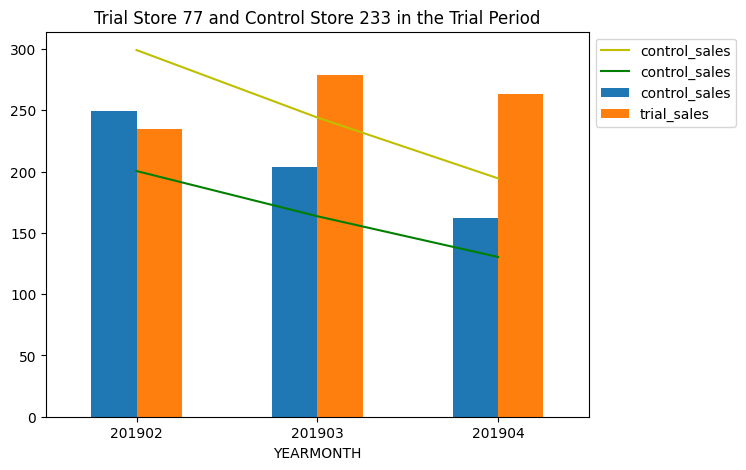

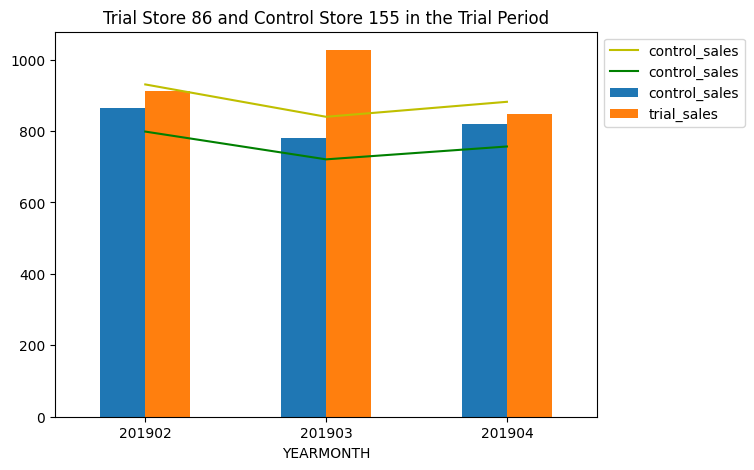

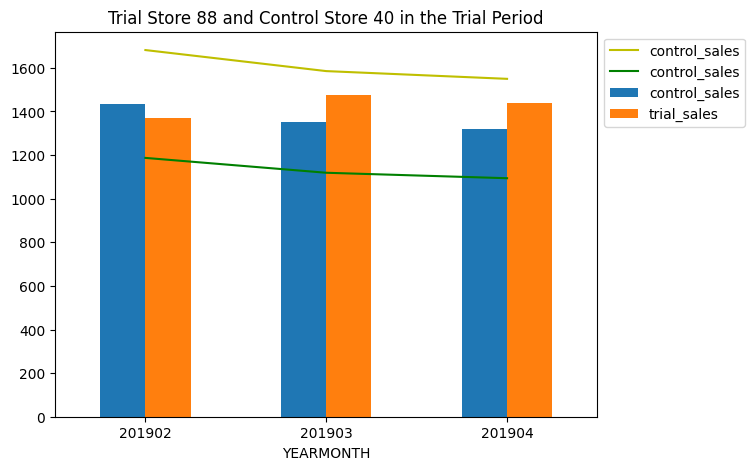

In [19]:
# First do bar graphs during the trial period
storepair = [[77, 233], [86, 155], [88, 40]]
for stores in storepair: # stores numbers are stored as [trial, control] in storepair
    trial = stores[0]
    control = stores[1]

    # Plot the bar chart of sales performance
    plot_control = percentdiff[(percentdiff['CONTROL_NBR'] == control) & (percentdiff.YEARMONTH >= 201902) & (percentdiff.YEARMONTH <= 201904)]\
                    [['YEARMONTH', 'CONTROL_NBR', 'scaled_sales_c']]
    plot_control = plot_control.rename(columns = {"CONTROL_NBR" : "STORE_NBR", "scaled_sales_c": "control_sales"})
    plot_trial = percentdiff[(percentdiff['TRIAL_NBR'] == trial) & (percentdiff.YEARMONTH >= 201902) & (percentdiff.YEARMONTH <= 201904)]\
                    [['YEARMONTH', 'TRIAL_NBR', 'tot_sales_t']]
    plot_trial = plot_trial.rename(columns = {"TRIAL_NBR" : "STORE_NBR", "tot_sales_t": "trial_sales"})
    toplot = plot_control[["YEARMONTH", "control_sales"]].merge(plot_trial[["YEARMONTH", "trial_sales"]],on="YEARMONTH").set_index("YEARMONTH")
    ax = toplot.plot(kind = 'bar',  figsize=(7, 5))


    # plot the thresholds as lines
    std = percentdiff[(percentdiff['CONTROL_NBR'] == control) & (percentdiff.YEARMONTH < 201902)]['sales_percent_diff'].std()
    threshold95 = plot_control.reset_index()[['YEARMONTH', 'control_sales']]
    threshold95.control_sales = threshold95.control_sales*(1+std*2)
    threshold5 = plot_control.reset_index()[['YEARMONTH', 'control_sales']]
    threshold5.control_sales = threshold5.control_sales*(1-std*2)
    ax95 = threshold95.plot.line(x = 'YEARMONTH', y = 'control_sales',color='y', figsize=(7, 5), use_index=False, ax = ax)
    ax5 = threshold5.plot.line(x = 'YEARMONTH', y = 'control_sales', color='g', figsize=(7, 5), use_index=False, ax = ax)

    # Other plot features
    plt.legend(loc = "upper left",bbox_to_anchor=(1.0, 1.0))
    titlestr = 'Trial Store ' + str(trial) + ' and Control Store ' + str(control) + ' in the Trial Period'
    ax.set_title(titlestr)
    plt.show()

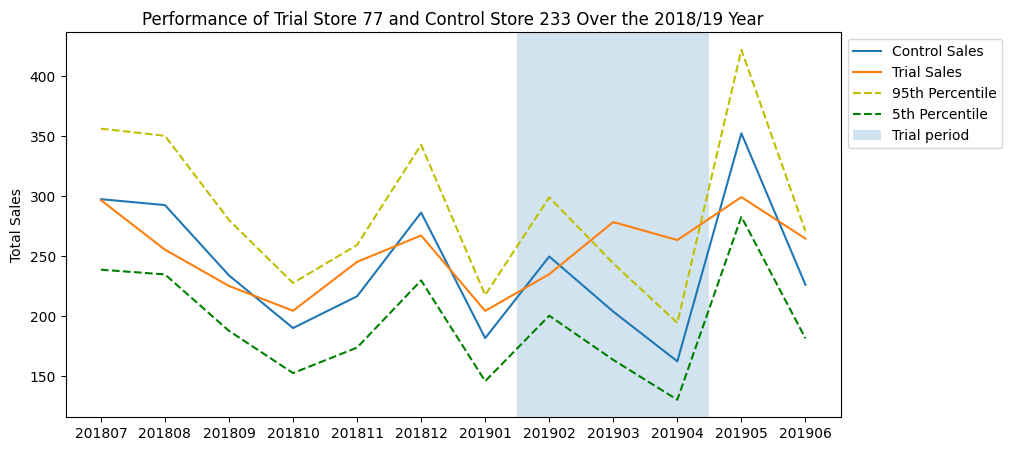

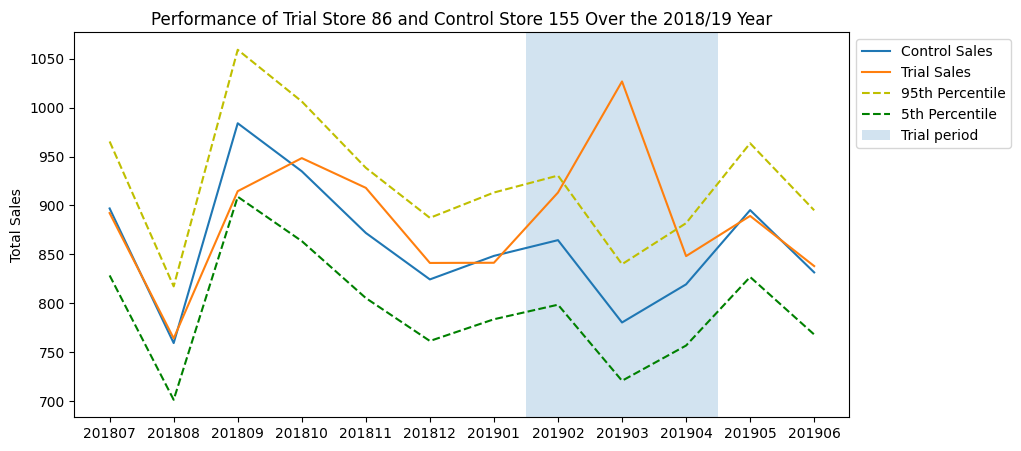

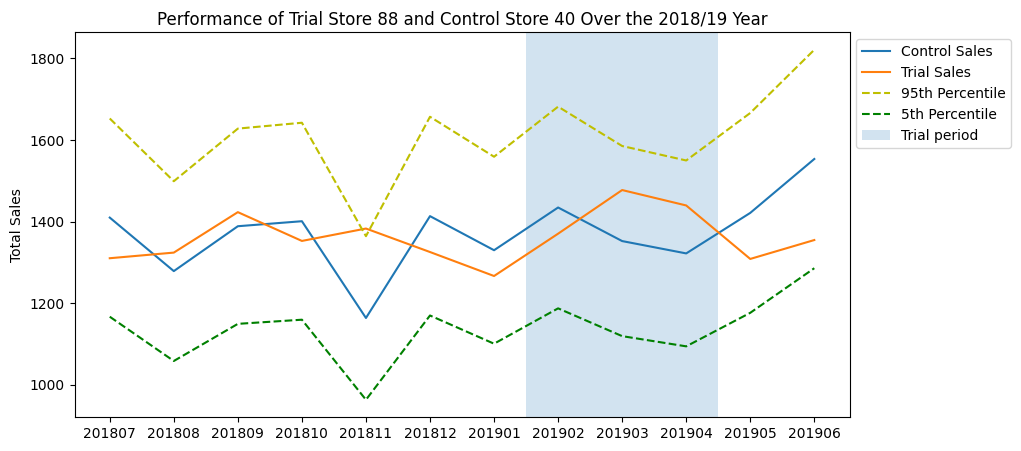

In [20]:
# Then do line graphs during the whole year - for the report
from matplotlib.patches import Rectangle
storepair = [[77, 233], [86, 155], [88, 40]]
for stores in storepair: # stores numbers are stored as [trial, control] in storepair
    trial = stores[0]
    control = stores[1]

    # Plot the line graph of sales performance
    plot_control = percentdiff[(percentdiff['CONTROL_NBR'] == control)][['YEARMONTH', 'CONTROL_NBR', 'scaled_sales_c']]
    plot_control = plot_control.rename(columns = {"CONTROL_NBR" : "STORE_NBR", "scaled_sales_c": "control_sales"})
    plot_trial = percentdiff[(percentdiff['TRIAL_NBR'] == trial)][['YEARMONTH', 'TRIAL_NBR', 'tot_sales_t']]
    plot_trial = plot_trial.rename(columns = {"TRIAL_NBR" : "STORE_NBR", "tot_sales_t": "trial_sales"})

    ax = plot_control.plot.line(x = "YEARMONTH", y = 'control_sales', use_index=False, label = 'Control Sales')
    ax_trial = plot_trial.plot.line(x = "YEARMONTH", y = 'trial_sales', use_index=False, ax=ax, label = 'Trial Sales')


    # plot the thresholds as lines
    std = percentdiff[(percentdiff['CONTROL_NBR'] == control) & (percentdiff.YEARMONTH < 201902)]['sales_percent_diff'].std()
    threshold95 = plot_control.reset_index()[['YEARMONTH', 'control_sales']]
    threshold95.control_sales = threshold95.control_sales*(1+std*2)
    threshold5 = plot_control.reset_index()[['YEARMONTH', 'control_sales']]
    threshold5.control_sales = threshold5.control_sales*(1-std*2)
    ax95 = threshold95.plot.line(x = 'YEARMONTH', y = 'control_sales',color='y', linestyle = '--', figsize=(10, 5), use_index=False, ax = ax, label = '95th Percentile')
    ax5 = threshold5.plot.line(x = 'YEARMONTH', y = 'control_sales', color='g',  linestyle = '--', figsize=(10, 5), use_index=False, ax = ax, label = '5th Percentile')
    ax.add_patch(Rectangle((6.5, 0), 3, 2000, alpha = 0.2, label = 'Trial period'))

    # Other plot features
    ax.set_ylabel('Total Sales')
    plt.legend(loc = "upper left",bbox_to_anchor=(1.0, 1.0))
    titlestr = 'Performance of Trial Store ' + str(trial) + ' and Control Store ' + str(control) + ' Over the 2018/19 Year'
    positions = (0,1,2,3,4,5,6,7,8,9, 10, 11)
    labels = ("201807", '201808', '201809', '201810', '201811', '201812', '201901', '201902', '201903', '201904', '201905', '201906')
    plt.xticks (positions, labels)
    ax.set_title(titlestr)
    plt.show()

The results show that the trial in store 77 is significantly different to its control store in the trial period as the trial store performance lies outside the 5% to 95% confidence interval of the control store in two of the three trial months.

For store 86, we can see that the trial in March is significantly different to the control store with the total sales performance outside of the 5% to 95% confidence interval. However, there is no significant difference in February's and April's performance.

The results for store 88 show no significant difference between the trial and control stores during this period.

The results for store 88 show no significant difference between the trial and control stores during this period.

In [21]:
# Calculate the scaling factor for the store pairs
scale_store77 = pretrial_metrics[pretrial_metrics.STORE_NBR == 77]['n_cust'].sum()/pretrial_metrics[pretrial_metrics.STORE_NBR == 233]['n_cust'].sum()
scale_store86 = pretrial_metrics[pretrial_metrics.STORE_NBR == 86]['n_cust'].sum()/pretrial_metrics[pretrial_metrics.STORE_NBR == 155]['n_cust'].sum()
scale_store88 = pretrial_metrics[pretrial_metrics.STORE_NBR == 88]['n_cust'].sum()/pretrial_metrics[pretrial_metrics.STORE_NBR == 40]['n_cust'].sum()

In [22]:
# Extract the control store data from the df and scale according to the store
scaled_control233 = metrics_df[metrics_df.STORE_NBR.isin([233])][['STORE_NBR', "YEARMONTH", 'n_cust']]
scaled_control233.n_cust *= scale_store77
scaled_control155 = metrics_df[metrics_df.STORE_NBR.isin([155])][['STORE_NBR', "YEARMONTH", 'n_cust']]
scaled_control155.n_cust *= scale_store86
scaled_control40 = metrics_df[metrics_df.STORE_NBR.isin([40])][['STORE_NBR', "YEARMONTH", 'n_cust']]
scaled_control40.n_cust *= scale_store88

# Combine the scaled control stores to a single df
scaledncust_control = pd.concat([scaled_control233, scaled_control155, scaled_control40]).reset_index(drop = True)
scaledncust_control = scaledncust_control.rename(columns = {'n_cust':'scaled_n_cust', 'STORE_NBR': 'CONTROL_NBR'})
# Get the trial period of scaled control stores
scaledncust_control_trial = scaledncust_control[(scaledsales_control.YEARMONTH>=201902) & (scaledsales_control.YEARMONTH<=201904)].reset_index(drop = True)

# Get the trial period of the trial stores
trialncust = metrics_df[metrics_df.STORE_NBR.isin([77,86,88])][['STORE_NBR', "YEARMONTH", 'n_cust']].reset_index(drop = True)
trialncust = trialncust.rename(columns = {'STORE_NBR': 'TRIAL_NBR'})
trialncust_trial = trialncust[(trialncust.YEARMONTH >= 201902) & (trialsales.YEARMONTH <= 201904)].reset_index(drop = True)

In [23]:
# Calculate the percentage difference between the control and trial store pairs for each month over the year
percentdiff = scaledncust_control.copy()
percentdiff[['TRIAL_NBR', 'n_cust_t']] = trialncust[['TRIAL_NBR', 'n_cust']]
percentdiff = percentdiff.rename(columns = {'scaled_n_cust' : 'scaled_n_cust_c'})
percentdiff['cust_percent_diff'] = (percentdiff.n_cust_t-percentdiff.scaled_n_cust_c)\
                                    /(0.5*((percentdiff.scaled_n_cust_c+percentdiff.n_cust_t)))
percentdiff.head()

,CONTROL_NBR,YEARMONTH,scaled_n_cust_c,TRIAL_NBR,n_cust_t,cust_percent_diff
0,233,201807,51.171141,77,51,-0.003350
1,233,201808,48.161074,77,47,-0.024402
2,233,201809,42.140940,77,42,-0.003350
3,233,201810,35.117450,77,37,0.052208
4,233,201811,40.134228,77,41,0.021342


In [24]:
# As our null hypothesis is that the trial period is the same as the pre-trial period,
# let's take the standard deviation based on the scaled percentage difference in the pre-trial period.
pretrial_percentdiff = percentdiff[percentdiff.YEARMONTH < 201902]
pretrial_percentdiff_std = pretrial_percentdiff.groupby(['TRIAL_NBR'])['cust_percent_diff'].agg('std').reset_index()
dof = 6 # 7 months of data - 1

for stores in storepair: # stores numbers are stored as [trial, control] in storepair
    trialstore = stores[0]
    controlstore = stores[1]
    pretrial = percentdiff[(percentdiff.YEARMONTH < 201902) & (percentdiff.TRIAL_NBR == trialstore)]
    std = pretrial['cust_percent_diff'].agg('std')
    mean =  pretrial['cust_percent_diff'].agg('mean')
    trialperiod = percentdiff[(percentdiff.YEARMONTH >= 201902) & (percentdiff.YEARMONTH <= 201904) \
                              & (percentdiff.TRIAL_NBR == trialstore)]
    print("Trial store -", trialstore, "; control store -", controlstore)
    print("Month : t-statistic")
    for month in trialperiod.YEARMONTH.unique():
        xval = trialperiod[trialperiod.YEARMONTH == month]['cust_percent_diff'].item()
        tstat = ((xval - mean)/std)
        print(str(month), ' : ', tstat)
    print()

# Generate the t-statistic for the 95% percentile with 6 dof
print ('95th percentile value:', stats.t.ppf(1-0.05, 6))

Trial store - 77 ; control store - 233
Month : t-statistic
201902  :  -0.19886295797440687
201903  :  8.009609025380932
201904  :  16.114474772873923

Trial store - 86 ; control store - 155
Month : t-statistic
201902  :  6.220524882227514
201903  :  10.52599074274189
201904  :  3.0763575852842706

Trial store - 88 ; control store - 40
Month : t-statistic
201902  :  -0.3592881735131531
201903  :  1.2575196020616801
201904  :  0.6092905590514273

95th percentile value: 1.9431802803927816


We can see from the above results that similar to the total sales metric, there are statistically significant increases in the number of customers in stores 77 and 86 in at least 2 months during the trial period. However, there is no significant increase in store 88.

Let's create a more visual version of this by plotting the sales of the control store, the sales of the trial stores and the 95th percentile value of sales of the control store.

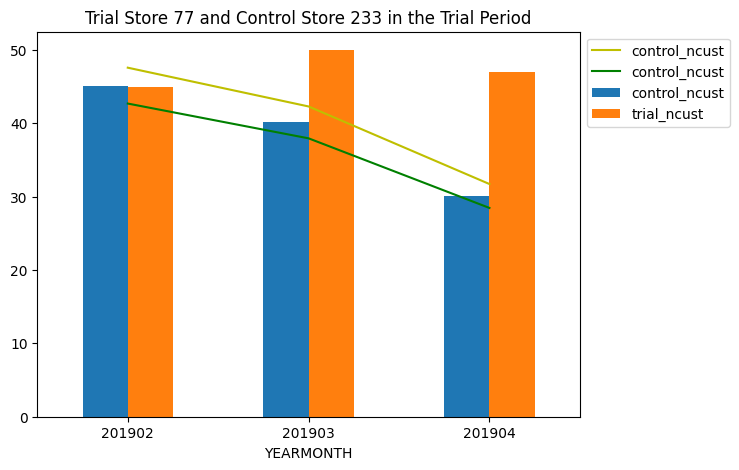

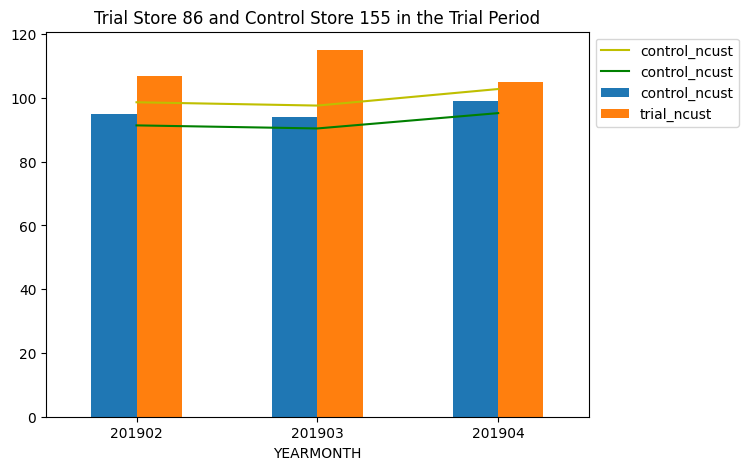

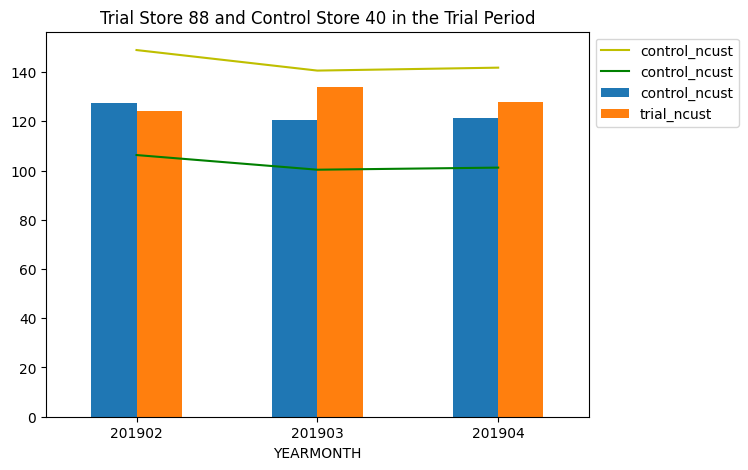

In [25]:
# First do bar charts to focus on the trial period
storepair = [[77, 233], [86, 155], [88, 40]]
for stores in storepair: # stores numbers are stored as [trial, control] in storepair
    trial = stores[0]
    control = stores[1]
    plot_control = percentdiff[(percentdiff['CONTROL_NBR'] == control) & (percentdiff.YEARMONTH >= 201902) & (percentdiff.YEARMONTH <= 201904)]\
                    [['YEARMONTH', 'CONTROL_NBR', 'scaled_n_cust_c']]
    plot_control = plot_control.rename(columns = {"CONTROL_NBR" : "STORE_NBR", "scaled_n_cust_c": "control_ncust"})
    plot_trial = percentdiff[(percentdiff['TRIAL_NBR'] == trial) & (percentdiff.YEARMONTH >= 201902) & (percentdiff.YEARMONTH <= 201904)]\
                    [['YEARMONTH', 'TRIAL_NBR', 'n_cust_t']]
    plot_trial = plot_trial.rename(columns = {"TRIAL_NBR" : "STORE_NBR", "n_cust_t": "trial_ncust"})
    toplot = plot_control[["YEARMONTH", "control_ncust"]].merge(plot_trial[["YEARMONTH", "trial_ncust"]],on="YEARMONTH").set_index("YEARMONTH")
    ax = toplot.plot(kind = 'bar',  figsize=(7, 5))


    # plot the thresholds as lines
    std = percentdiff[(percentdiff['CONTROL_NBR'] == control) & (percentdiff.YEARMONTH < 201902)]['cust_percent_diff'].std()
    threshold95 = plot_control.reset_index()[['YEARMONTH', 'control_ncust']]
    threshold95.control_ncust = threshold95.control_ncust*(1+std*2)
    threshold5 = plot_control.reset_index()[['YEARMONTH', 'control_ncust']]
    threshold5.control_ncust = threshold5.control_ncust*(1-std*2)
    ax95 = threshold95.plot.line(x = 'YEARMONTH', y = 'control_ncust',color='y', figsize=(7, 5), use_index=False, ax = ax)
    ax5 = threshold5.plot.line(x = 'YEARMONTH', y = 'control_ncust', color='g', figsize=(7, 5), use_index=False, ax = ax)

    # Other plot features
    plt.legend(loc = "upper left",bbox_to_anchor=(1.0, 1.0))
    titlestr = 'Trial Store ' + str(trial) + ' and Control Store ' + str(control) + ' in the Trial Period'
    ax.set_title(titlestr)
    plt.show()